In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import splitfolders
import pickle
import sys
sys.path.append('..')
from plot_tools import set_size
from SIplots import morph_cnn_plot

In [2]:
data_dir = 'D://cavity_images//mask_bbox//'

In [43]:
splitfolders.ratio(data_dir + 'raw', 
                   output=data_dir + "output", 
                   seed=42, 
                   ratio=(.7, .2, .1), 
                   group_prefix=None) # default values

In [3]:
batch_size = 32
img_height = 80
img_width = 80

In [4]:
datagen = ImageDataGenerator()

In [5]:
train_generator = datagen.flow_from_directory(
    directory=data_dir+ 'output/train',
    target_size=(80,80),
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42
)
valid_generator = datagen.flow_from_directory(
    directory=data_dir+ 'output/val',
    target_size=(80,80),
    color_mode="grayscale",
    batch_size=32,
    class_mode="binary",
    shuffle=True,
    seed=42
)
test_generator = datagen.flow_from_directory(
    directory=data_dir+ 'output/test',
    target_size=(80,80),
    color_mode="grayscale",
    batch_size=1,
    class_mode="binary",
    shuffle=True,
    seed=42
)

Found 1031 images belonging to 2 classes.
Found 294 images belonging to 2 classes.
Found 149 images belonging to 2 classes.


In [6]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [61]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(80, 80,1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 78, 78, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 39, 39, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 39, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)       

In [63]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [64]:
checkpoint_dir = './logs/masks/weights.hdf5'

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',restore_best_weights=True,
                                                 mode='auto',
                                                 save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [65]:
history = model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_generator,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=100,callbacks=[cp_callback,early])

Epoch 1/100
32/32 [==============================] - 5s 162ms/step - loss: 6.8446 - accuracy: 0.5265 - val_loss: 0.6779 - val_accuracy: 0.5521
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.6897 - accuracy: 0.5516 - val_loss: 0.6789 - val_accuracy: 0.6215
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.6872 - accuracy: 0.5445 - val_loss: 0.6711 - val_accuracy: 0.6111
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.6774 - accuracy: 0.5916 - val_loss: 0.6613 - val_accuracy: 0.6285
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.6702 - accuracy: 0.5836 - val_loss: 0.6578 - val_accuracy: 0.6354
Epoch 6/100
32/32 [==============================] - 0s 14ms/step - loss: 0.6802 - accuracy: 0.5646 - val_loss: 0.6570 - val_accuracy: 0.6354
Epoch 7/100
32/32 [==============================] - 0s 13ms/step - loss: 0.6640 - accuracy: 0.5976 - val_loss: 0.6634 - val_accuracy: 0.5903
Epoch

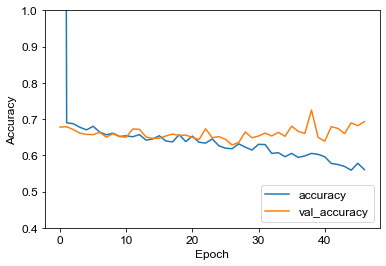

In [66]:
plt.plot(history.history['loss'], label='accuracy')
plt.plot(history.history['val_loss'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.legend(loc='lower right')
#plt.savefig('../figures/morphology_train.png')
plt.show()

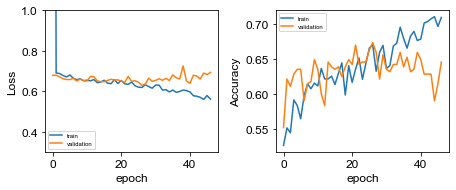

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=set_size(469.7,fraction=1,hratio=1.4,subplots=(1,2)))
plt.rcParams["font.family"] = "Arial"
plt.rc('font', size=12)
#fig.suptitle('Horizontally stacked subplots')

ax1.plot(history.history['loss'],label='train')
ax1.plot(history.history['val_loss'],label='validation')

ax2.plot(history.history['accuracy'],label='train')
ax2.plot(history.history['val_accuracy'],label='validation')

ax1.set_xlabel('epoch')
ax2.set_xlabel('epoch')

ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')

ax1.set_ylim(.3,1)
ax1.legend(loc='lower left',fontsize=6)
ax2.legend(loc='best',fontsize=6)

plt.tight_layout()
plt.show()
#plt.savefig('loss_acc_curves')

In [72]:
with open('./trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [68]:
model.evaluate(test_generator)

149/149 [==============================] - 0s 2ms/step - loss: 0.6529 - accuracy: 0.6510


[0.6529419422149658, 0.6510066986083984]

In [73]:
with open('./trainHistoryDict', 'rb') as f:
    h = pickle.load(f)

In [75]:
h

{'loss': [6.844611167907715,
  0.6897252202033997,
  0.6871748566627502,
  0.6773698925971985,
  0.670177161693573,
  0.6801778674125671,
  0.6639842391014099,
  0.6566519737243652,
  0.6609659790992737,
  0.6521216034889221,
  0.653810977935791,
  0.6512285470962524,
  0.6571338772773743,
  0.6418606042861938,
  0.6450730562210083,
  0.6539749503135681,
  0.6394466161727905,
  0.6369600296020508,
  0.6568900942802429,
  0.6378927826881409,
  0.6529277563095093,
  0.6360589861869812,
  0.6337795853614807,
  0.6452659964561462,
  0.6263821125030518,
  0.6196469664573669,
  0.6182311177253723,
  0.63177090883255,
  0.6224583387374878,
  0.6145682334899902,
  0.6303068399429321,
  0.6295775771141052,
  0.6052754521369934,
  0.6072174906730652,
  0.5961664319038391,
  0.6053797006607056,
  0.5941803455352783,
  0.598444938659668,
  0.6052913665771484,
  0.6026567220687866,
  0.596120297908783,
  0.5775132775306702,
  0.5746651887893677,
  0.5693286061286926,
  0.558952271938324,
  0.578071

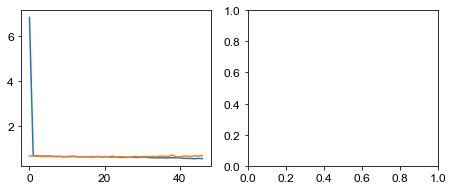

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=set_size(469.7,fraction=1,hratio=1.4,subplots=(1,2)))
plt.rcParams["font.family"] = "Arial"
plt.rc('font', size=12)
#fig.suptitle('Horizontally stacked subplots')

ax1.plot(h['loss'],label='train')
ax1.plot(h['val_loss'],label='validation')


plt.tight_layout()
plt.show()

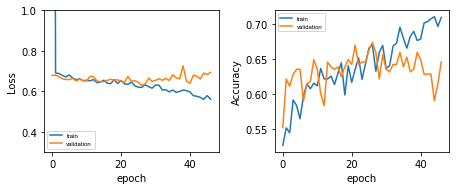

In [2]:
morph_cnn_plot(save=True)